In [1]:
import torch
import torchvision.datasets
import torchvision.models
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch.nn as nn
from tqdm import tqdm
from train_utils import get_data_loaders, train, test
from PIL import Image
import pandas as pd
from convnet import ConvNet

In [2]:
root = './distilled_dataset'

### Augmentation

In [ ]:
def get_daparam(dataset, model, model_eval, ipc):
    # We find that augmentation doesn't always benefit the performance.
    # So we do augmentation for some of the settings.

    dc_aug_param = dict()
    dc_aug_param['crop'] = 4
    dc_aug_param['scale'] = 0.2
    dc_aug_param['rotate'] = 45
    dc_aug_param['noise'] = 0.001
    dc_aug_param['strategy'] = 'none'

    if dataset == 'MNIST':
        dc_aug_param['strategy'] = 'crop_scale_rotate'

    if model_eval in ['ConvNetBN']:  # Data augmentation makes model training with Batch Norm layer easier.
        dc_aug_param['strategy'] = 'crop_noise'

    return dc_aug_param

class ParamDiffAug():
    def __init__(self):
        self.aug_mode = 'S' #'multiple or single'
        self.prob_flip = 0.5
        self.ratio_scale = 1.2
        self.ratio_rotate = 15.0
        self.ratio_crop_pad = 0.125
        self.ratio_cutout = 0.5 # the size would be 0.5x0.5
        self.ratio_noise = 0.05
        self.brightness = 1.0
        self.saturation = 2.0
        self.contrast = 0.5

def set_seed_DiffAug(param):
    if param.latestseed == -1:
        return
    else:
        torch.random.manual_seed(param.latestseed)
        param.latestseed += 1

def rand_scale(x, param):
    # x>1, max scale
    # sx, sy: (0, +oo), 1: orignial size, 0.5: enlarge 2 times
    ratio = param.ratio_scale
    set_seed_DiffAug(param)
    sx = torch.rand(x.shape[0]) * (ratio - 1.0/ratio) + 1.0/ratio
    set_seed_DiffAug(param)
    sy = torch.rand(x.shape[0]) * (ratio - 1.0/ratio) + 1.0/ratio
    theta = [[[sx[i], 0,  0],
            [0,  sy[i], 0],] for i in range(x.shape[0])]
    theta = torch.tensor(theta, dtype=torch.float)
    if param.batchmode: # batch-wise:
        theta[:] = theta[0]
    grid = F.affine_grid(theta, x.shape, align_corners=True).to(x.device)
    x = F.grid_sample(x, grid, align_corners=True)
    return x


def rand_rotate(x, param): # [-180, 180], 90: anticlockwise 90 degree
    ratio = param.ratio_rotate
    set_seed_DiffAug(param)
    theta = (torch.rand(x.shape[0]) - 0.5) * 2 * ratio / 180 * float(np.pi)
    theta = [[[torch.cos(theta[i]), torch.sin(-theta[i]), 0],
        [torch.sin(theta[i]), torch.cos(theta[i]),  0],]  for i in range(x.shape[0])]
    theta = torch.tensor(theta, dtype=torch.float)
    if param.batchmode: # batch-wise:
        theta[:] = theta[0]
    grid = F.affine_grid(theta, x.shape, align_corners=True).to(x.device)
    x = F.grid_sample(x, grid, align_corners=True)
    return x


def rand_flip(x, param):
    prob = param.prob_flip
    set_seed_DiffAug(param)
    randf = torch.rand(x.size(0), 1, 1, 1, device=x.device)
    if param.batchmode: # batch-wise:
        randf[:] = randf[0]
    return torch.where(randf < prob, x.flip(3), x)


def rand_brightness(x, param):
    ratio = param.brightness
    set_seed_DiffAug(param)
    randb = torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device)
    if param.batchmode:  # batch-wise:
        randb[:] = randb[0]
    x = x + (randb - 0.5)*ratio
    return x


def rand_saturation(x, param):
    ratio = param.saturation
    x_mean = x.mean(dim=1, keepdim=True)
    set_seed_DiffAug(param)
    rands = torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device)
    if param.batchmode:  # batch-wise:
        rands[:] = rands[0]
    x = (x - x_mean) * (rands * ratio) + x_mean
    return x


def rand_contrast(x, param):
    ratio = param.contrast
    x_mean = x.mean(dim=[1, 2, 3], keepdim=True)
    set_seed_DiffAug(param)
    randc = torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device)
    if param.batchmode:  # batch-wise:
        randc[:] = randc[0]
    x = (x - x_mean) * (randc + ratio) + x_mean
    return x


def rand_crop(x, param):
    # The image is padded on its surrounding and then cropped.
    ratio = param.ratio_crop_pad
    shift_x, shift_y = int(x.size(2) * ratio + 0.5), int(x.size(3) * ratio + 0.5)
    set_seed_DiffAug(param)
    translation_x = torch.randint(-shift_x, shift_x + 1, size=[x.size(0), 1, 1], device=x.device)
    set_seed_DiffAug(param)
    translation_y = torch.randint(-shift_y, shift_y + 1, size=[x.size(0), 1, 1], device=x.device)
    if param.batchmode:  # batch-wise:
        translation_x[:] = translation_x[0]
        translation_y[:] = translation_y[0]
    grid_batch, grid_x, grid_y = torch.meshgrid(
        torch.arange(x.size(0), dtype=torch.long, device=x.device),
        torch.arange(x.size(2), dtype=torch.long, device=x.device),
        torch.arange(x.size(3), dtype=torch.long, device=x.device),
    )
    grid_x = torch.clamp(grid_x + translation_x + 1, 0, x.size(2) + 1)
    grid_y = torch.clamp(grid_y + translation_y + 1, 0, x.size(3) + 1)
    x_pad = F.pad(x, [1, 1, 1, 1, 0, 0, 0, 0])
    x = x_pad.permute(0, 2, 3, 1).contiguous()[grid_batch, grid_x, grid_y].permute(0, 3, 1, 2)
    return x


def rand_cutout(x, param):
    ratio = param.ratio_cutout
    cutout_size = int(x.size(2) * ratio + 0.5), int(x.size(3) * ratio + 0.5)
    set_seed_DiffAug(param)
    offset_x = torch.randint(0, x.size(2) + (1 - cutout_size[0] % 2), size=[x.size(0), 1, 1], device=x.device)
    set_seed_DiffAug(param)
    offset_y = torch.randint(0, x.size(3) + (1 - cutout_size[1] % 2), size=[x.size(0), 1, 1], device=x.device)
    if param.batchmode:  # batch-wise:
        offset_x[:] = offset_x[0]
        offset_y[:] = offset_y[0]
    grid_batch, grid_x, grid_y = torch.meshgrid(
        torch.arange(x.size(0), dtype=torch.long, device=x.device),
        torch.arange(cutout_size[0], dtype=torch.long, device=x.device),
        torch.arange(cutout_size[1], dtype=torch.long, device=x.device),
    )
    grid_x = torch.clamp(grid_x + offset_x - cutout_size[0] // 2, min=0, max=x.size(2) - 1)
    grid_y = torch.clamp(grid_y + offset_y - cutout_size[1] // 2, min=0, max=x.size(3) - 1)
    mask = torch.ones(x.size(0), x.size(2), x.size(3), dtype=x.dtype, device=x.device)
    mask[grid_batch, grid_x, grid_y] = 0
    x = x * mask.unsqueeze(1)
    return x


AUGMENT_FNS = {
    'color': [rand_brightness, rand_saturation, rand_contrast],
    'crop': [rand_crop],
    'cutout': [rand_cutout],
    'flip': [rand_flip],
    'scale': [rand_scale],
    'rotate': [rand_rotate],
}

def DiffAugment(x, strategy='', seed = -1, param = None):
    if seed == -1:
        param.batchmode = False
    else:
        param.batchmode = True

    param.latestseed = seed

    if strategy == 'None' or strategy == 'none':
        return x

    if strategy:
        if param.aug_mode == 'M': # original
            for p in strategy.split('_'):
                for f in AUGMENT_FNS[p]:
                    x = f(x, param)
        elif param.aug_mode == 'S':
            pbties = strategy.split('_')
            set_seed_DiffAug(param)
            p = pbties[torch.randint(0, len(pbties), size=(1,)).item()]
            for f in AUGMENT_FNS[p]:
                x = f(x, param)
        else:
            exit('Error ZH: unknown augmentation mode.')
        x = x.contiguous()
    return x

"""
    dsa augmentation during training
"""
dsa_param = ParamDiffAug()
dsa_strategy = 'color_crop_cutout_flip_scale_rotate'
img = DiffAugment(img, dsa_strategy, param=dsa_param)

### CIFAR10 Distilled

In [3]:
class CIFAR10_Distilled(Dataset):
    def __init__(self, idx_df, transform):
        self.idx_df = idx_df
        self.transform = transform
    
    def __len__(self):
        return len(self.idx_df)

    def __getitem__(self, index):
        entry = self.idx_df.iloc[index]
        image = self.transform(Image.open(entry.image_path))
        label = entry.label
        return image, label

In [4]:
index_file = pd.read_csv('./CIFAR10_DM_index_files/ipc500_idx.csv')
index_file

,image_path,label
0,./CIFAR10_DM/ipc500/airplane/003746e7-c915-4d7...,0
1,./CIFAR10_DM/ipc500/airplane/0090a052-69a0-461...,0
2,./CIFAR10_DM/ipc500/airplane/0143960d-3978-448...,0
3,./CIFAR10_DM/ipc500/airplane/01ee79d8-a8fe-430...,0
4,./CIFAR10_DM/ipc500/airplane/0231edfd-42fd-477...,0
...,...,...
4995,./CIFAR10_DM/ipc500/truck/fb1fbeaf-b6c7-4da4-a...,9
4996,./CIFAR10_DM/ipc500/truck/fcd9e0b0-9b62-4d41-8...,9
4997,./CIFAR10_DM/ipc500/truck/fdefdd6d-2fd9-42f1-b...,9
4998,./CIFAR10_DM/ipc500/truck/ff83d309-da9a-459a-a...,9


In [5]:
image_normalize= transforms.Lambda(lambda img: 2 * img / 255. - 1) # normalize to [-1, 1]
# https://github.com/Lornatang/pytorch-alexnet-cifar100/blob/master/utils/datasets.py
transform = transforms.Compose([
                                # transforms.Resize(128),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                # image_normalize,
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                              ])
cifar10_distilled_train = CIFAR10_Distilled(index_file, transform)

cifar10_root = '../cifar10'
cifar10_test = torchvision.datasets.CIFAR10(cifar10_root,
                                            train=False,
                                            transform=transforms.Compose([
                                                # transforms.Resize(128),
                                                transforms.ToTensor(),
                                                # image_normalize,
                                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                              ]))

In [ ]:
"""
    ZCA whitening before training
"""
# !pip install kornia
import kornia as K
from torch.utils.data import TensorDataset

images = []
labels = []
print("Train ZCA")
for i in tqdm.tqdm(range(len(cifar10_distilled_train))):
    im, lab = cifar10_distilled_train[i]
    images.append(im)
    labels.append(lab)
images = torch.stack(images, dim=0).to("cpu")
labels = torch.tensor(labels, dtype=torch.long, device="cpu")
zca = K.enhance.ZCAWhitening(eps=0.1, compute_inv=True)
zca.fit(images)
zca_images = zca(images).to("cpu")
dst_train = TensorDataset(zca_images, labels)


images = []
labels = []
print("Test ZCA")
for i in tqdm.tqdm(range(len(cifar10_test))):
    im, lab = cifar10_test[i]
    images.append(im)
    labels.append(lab)
images = torch.stack(images, dim=0).to("cpu")
labels = torch.tensor(labels, dtype=torch.long, device="cpu")

zca_images = zca(images).to("cpu")
dst_test = TensorDataset(zca_images, labels)

In [6]:
batch_size = 32 # cut batch size to half for ipc50
# train_data_loader, test_data_loader = get_data_loaders(cifar10_distilled_train, cifar10_test, batch_size=batch_size)
train_data_loader, test_data_loader = get_data_loaders(dst_train, dst_test, batch_size=batch_size)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"[INFO]: Computation device: {device}")

[INFO]: Computation device: cuda


In [8]:
import os

model_name = 'ConvNetD3'
dataset = 'cifar10_distilled'
model_path = f'./model_weight/{dataset}/{model_name}/'
if not os.path.exists(model_path):
    os.makedirs(model_path)
# Following ConvNetD3's definition from the DATM paper, but first one changed to 32 from 128
net_width, net_depth, net_act, net_norm, net_pooling = 32, 3, 'relu', 'instancenorm', 'avgpooling'
model = ConvNet(channel=3, num_classes=10, net_width=net_width, net_depth=3, net_act=net_act, net_norm=net_norm, net_pooling=net_pooling)

In [9]:
train_record, test_record  = train(model, model_path, train_data_loader, test_data_loader, num_epochs=100)

Epoch 1: 100%|██████████| 157/157 [00:03<00:00, 40.30it/s, loss=0.71] 


epoch: 1 done, loss: 0.032749243080616
Acc: 0.4349
[0.001]


Epoch 2: 100%|██████████| 157/157 [00:03<00:00, 45.52it/s, loss=0.632]


epoch: 2 done, loss: 0.014309542253613472
Acc: 0.4404
[0.001]


Epoch 3: 100%|██████████| 157/157 [00:03<00:00, 48.23it/s, loss=0.251]


epoch: 3 done, loss: 0.010110079310834408
Acc: 0.4973
[0.001]


Epoch 4: 100%|██████████| 157/157 [00:03<00:00, 47.11it/s, loss=0.131] 


epoch: 4 done, loss: 0.00733800558373332
Acc: 0.5132
[0.001]


Epoch 5: 100%|██████████| 157/157 [00:03<00:00, 47.33it/s, loss=0.331] 


epoch: 5 done, loss: 0.006036317441612482
Acc: 0.5154
[0.001]


Epoch 6: 100%|██████████| 157/157 [00:03<00:00, 47.60it/s, loss=0.484] 


epoch: 6 done, loss: 0.005048071034252644
Acc: 0.517
[0.001]


Epoch 7: 100%|██████████| 157/157 [00:03<00:00, 42.11it/s, loss=0.0892]


epoch: 7 done, loss: 0.004484888631850481
Acc: 0.5344
[0.001]


Epoch 8: 100%|██████████| 157/157 [00:03<00:00, 44.43it/s, loss=0.228] 


epoch: 8 done, loss: 0.0036859430838376284
Acc: 0.5348
[0.001]


Epoch 9: 100%|██████████| 157/157 [00:03<00:00, 43.35it/s, loss=0.0691]


epoch: 9 done, loss: 0.0031415841076523066
Acc: 0.5414
[0.001]


Epoch 10: 100%|██████████| 157/157 [00:03<00:00, 42.40it/s, loss=0.00552]


epoch: 10 done, loss: 0.002953861141577363
Acc: 0.5406
[0.001]


Epoch 11: 100%|██████████| 157/157 [00:03<00:00, 43.28it/s, loss=0.0291]


epoch: 11 done, loss: 0.002672737929970026
Acc: 0.5428
[0.001]


Epoch 12: 100%|██████████| 157/157 [00:03<00:00, 42.70it/s, loss=0.132]  


epoch: 12 done, loss: 0.002235200721770525
Acc: 0.5587
[0.001]


Epoch 13: 100%|██████████| 157/157 [00:03<00:00, 45.11it/s, loss=0.00786]


epoch: 13 done, loss: 0.0022550527937710285
Acc: 0.551
[0.001]


Epoch 14: 100%|██████████| 157/157 [00:03<00:00, 44.73it/s, loss=0.00232]


epoch: 14 done, loss: 0.0017036325298249722
Acc: 0.5452
[0.001]


Epoch 15: 100%|██████████| 157/157 [00:03<00:00, 40.92it/s, loss=0.0274] 


epoch: 15 done, loss: 0.0018152513075619936
Acc: 0.5527
[0.001]


Epoch 16: 100%|██████████| 157/157 [00:03<00:00, 43.62it/s, loss=0.00736]


epoch: 16 done, loss: 0.001377531560137868
Acc: 0.5492
[0.001]


Epoch 17: 100%|██████████| 157/157 [00:03<00:00, 45.79it/s, loss=0.0175] 


epoch: 17 done, loss: 0.0018136880826205015
Acc: 0.5526
[0.001]


Epoch 18: 100%|██████████| 157/157 [00:03<00:00, 43.79it/s, loss=0.0471] 


epoch: 18 done, loss: 0.0014131737407296896
Acc: 0.5652
[0.001]


Epoch 19: 100%|██████████| 157/157 [00:03<00:00, 44.12it/s, loss=0.00682]


epoch: 19 done, loss: 0.001004066551104188
Acc: 0.5624
[0.001]


Epoch 20: 100%|██████████| 157/157 [00:03<00:00, 42.56it/s, loss=0.0261] 


epoch: 20 done, loss: 0.0010662992717698216
Acc: 0.5478
[0.001]


Epoch 21: 100%|██████████| 157/157 [00:03<00:00, 44.44it/s, loss=0.00592]


epoch: 21 done, loss: 0.0009583566570654511
Acc: 0.5457
[0.001]


Epoch 22: 100%|██████████| 157/157 [00:03<00:00, 43.90it/s, loss=0.00336]


epoch: 22 done, loss: 0.0012303456896916032
Acc: 0.5639
[0.001]


Epoch 23: 100%|██████████| 157/157 [00:03<00:00, 45.51it/s, loss=0.0058] 


epoch: 23 done, loss: 0.0012954416451975703
Acc: 0.5494
[0.001]


Epoch 24: 100%|██████████| 157/157 [00:03<00:00, 41.74it/s, loss=0.013]  


epoch: 24 done, loss: 0.0010843006893992424
Acc: 0.5501
[0.001]


Epoch 25: 100%|██████████| 157/157 [00:04<00:00, 33.77it/s, loss=0.00288]


epoch: 25 done, loss: 0.0005842400714755058
Acc: 0.5532
[0.001]


Epoch 26: 100%|██████████| 157/157 [00:04<00:00, 38.42it/s, loss=0.0129] 


epoch: 26 done, loss: 0.0004473424341995269
Acc: 0.5705
[0.001]


Epoch 27: 100%|██████████| 157/157 [00:03<00:00, 41.53it/s, loss=0.000528]


epoch: 27 done, loss: 0.0003059314040001482
Acc: 0.5568
[0.001]


Epoch 28: 100%|██████████| 157/157 [00:03<00:00, 42.06it/s, loss=0.00468]


epoch: 28 done, loss: 0.0009235779289156199
Acc: 0.5527
[0.001]


Epoch 29: 100%|██████████| 157/157 [00:03<00:00, 42.27it/s, loss=0.0188] 


epoch: 29 done, loss: 0.0005355243338271976
Acc: 0.5639
[0.001]


Epoch 30: 100%|██████████| 157/157 [00:04<00:00, 36.18it/s, loss=0.00106]


epoch: 30 done, loss: 0.000482219154946506
Acc: 0.5542
[0.001]


Epoch 31: 100%|██████████| 157/157 [00:03<00:00, 40.02it/s, loss=0.0987]  


epoch: 31 done, loss: 0.0005960520938970149
Acc: 0.5429
[0.0001]


Epoch 32: 100%|██████████| 157/157 [00:04<00:00, 38.43it/s, loss=0.0119]  


epoch: 32 done, loss: 0.000375205185264349
Acc: 0.5654
[0.0001]


Epoch 33: 100%|██████████| 157/157 [00:04<00:00, 36.93it/s, loss=0.00169] 


epoch: 33 done, loss: 0.0001592386543052271
Acc: 0.5715
[0.0001]


Epoch 34: 100%|██████████| 157/157 [00:04<00:00, 37.68it/s, loss=0.000391]


epoch: 34 done, loss: 0.00012601373600773513
Acc: 0.5731
[0.0001]


Epoch 35: 100%|██████████| 157/157 [00:04<00:00, 36.63it/s, loss=0.000543]


epoch: 35 done, loss: 0.00011143145093228668
Acc: 0.5729
[0.0001]


Epoch 36: 100%|██████████| 157/157 [00:04<00:00, 36.95it/s, loss=0.0125]  


epoch: 36 done, loss: 9.897789277601987e-05
Acc: 0.5751
[0.0001]


Epoch 37: 100%|██████████| 157/157 [00:04<00:00, 36.66it/s, loss=0.0022]  


epoch: 37 done, loss: 9.571442933520302e-05
Acc: 0.5749
[0.0001]


Epoch 38: 100%|██████████| 157/157 [00:04<00:00, 36.34it/s, loss=0.000868]


epoch: 38 done, loss: 9.325275459559634e-05
Acc: 0.5729
[0.0001]


Epoch 39: 100%|██████████| 157/157 [00:04<00:00, 39.07it/s, loss=0.00295] 


epoch: 39 done, loss: 8.588117634644732e-05
Acc: 0.575
[0.0001]


Epoch 40: 100%|██████████| 157/157 [00:04<00:00, 35.93it/s, loss=0.000124]


epoch: 40 done, loss: 7.550593727501109e-05
Acc: 0.5751
[0.0001]


Epoch 41: 100%|██████████| 157/157 [00:04<00:00, 32.19it/s, loss=0.000169]


epoch: 41 done, loss: 7.400942558888346e-05
Acc: 0.5733
[0.0001]


Epoch 42: 100%|██████████| 157/157 [00:04<00:00, 33.59it/s, loss=0.000137]


epoch: 42 done, loss: 7.085403922246769e-05
Acc: 0.5748
[0.0001]


Epoch 43: 100%|██████████| 157/157 [00:04<00:00, 34.02it/s, loss=0.00467] 


epoch: 43 done, loss: 6.967619992792606e-05
Acc: 0.5763
[0.0001]


Epoch 44: 100%|██████████| 157/157 [00:04<00:00, 32.05it/s, loss=0.00468] 


epoch: 44 done, loss: 6.306887371465564e-05
Acc: 0.5778
[0.0001]


Epoch 45: 100%|██████████| 157/157 [00:04<00:00, 32.12it/s, loss=0.00146] 


epoch: 45 done, loss: 6.019984357408248e-05
Acc: 0.5762
[0.0001]


Epoch 46: 100%|██████████| 157/157 [00:04<00:00, 35.12it/s, loss=0.00233] 


epoch: 46 done, loss: 5.690954640158452e-05
Acc: 0.5762
[0.0001]


Epoch 47: 100%|██████████| 157/157 [00:04<00:00, 36.97it/s, loss=0.00192] 


epoch: 47 done, loss: 5.3415464208228514e-05
Acc: 0.5771
[0.0001]


Epoch 48: 100%|██████████| 157/157 [00:04<00:00, 33.02it/s, loss=0.000258]


epoch: 48 done, loss: 4.988474756828509e-05
Acc: 0.5763
[0.0001]


Epoch 49: 100%|██████████| 157/157 [00:04<00:00, 32.52it/s, loss=0.000168]


epoch: 49 done, loss: 5.0257847760804e-05
Acc: 0.5776
[0.0001]


Epoch 50: 100%|██████████| 157/157 [00:05<00:00, 29.84it/s, loss=0.000258]


epoch: 50 done, loss: 4.732205343316309e-05
Acc: 0.5783
[0.0001]


Epoch 51: 100%|██████████| 157/157 [00:05<00:00, 29.66it/s, loss=0.000942]


epoch: 51 done, loss: 4.828852252103388e-05
Acc: 0.578
[0.0001]


Epoch 52: 100%|██████████| 157/157 [00:05<00:00, 30.84it/s, loss=0.000388]


epoch: 52 done, loss: 4.31659136665985e-05
Acc: 0.5776
[0.0001]


Epoch 53: 100%|██████████| 157/157 [00:05<00:00, 31.14it/s, loss=0.005]   


epoch: 53 done, loss: 4.2372321331640705e-05
Acc: 0.5763
[0.0001]


Epoch 54: 100%|██████████| 157/157 [00:05<00:00, 28.65it/s, loss=0.00451] 


epoch: 54 done, loss: 4.246164098731242e-05
Acc: 0.5796
[0.0001]


Epoch 55: 100%|██████████| 157/157 [00:05<00:00, 29.99it/s, loss=0.00044] 


epoch: 55 done, loss: 4.074444223078899e-05
Acc: 0.578
[0.0001]


Epoch 56: 100%|██████████| 157/157 [00:04<00:00, 31.64it/s, loss=0.0012]  


epoch: 56 done, loss: 3.749557436094619e-05
Acc: 0.5783
[0.0001]


Epoch 57: 100%|██████████| 157/157 [00:05<00:00, 30.01it/s, loss=0.00096] 


epoch: 57 done, loss: 3.354938235133886e-05
Acc: 0.5784
[0.0001]


Epoch 58: 100%|██████████| 157/157 [00:04<00:00, 31.80it/s, loss=0.000119]


epoch: 58 done, loss: 3.42869789164979e-05
Acc: 0.5785
[0.0001]


Epoch 59: 100%|██████████| 157/157 [00:04<00:00, 32.09it/s, loss=0.000851]


epoch: 59 done, loss: 3.267947613494471e-05
Acc: 0.5777
[0.0001]


Epoch 60: 100%|██████████| 157/157 [00:04<00:00, 36.91it/s, loss=3.12e-5] 


epoch: 60 done, loss: 3.0095216061454266e-05
Acc: 0.5787
[0.0001]


Epoch 61: 100%|██████████| 157/157 [00:04<00:00, 36.81it/s, loss=0.000549]


epoch: 61 done, loss: 3.0104813049547374e-05
Acc: 0.5792
[0.0001]


Epoch 62: 100%|██████████| 157/157 [00:04<00:00, 31.73it/s, loss=0.000116]


epoch: 62 done, loss: 2.830420999089256e-05
Acc: 0.5782
[0.0001]


Epoch 63: 100%|██████████| 157/157 [00:05<00:00, 29.58it/s, loss=0.000201]


epoch: 63 done, loss: 2.7612577468971722e-05
Acc: 0.5782
[0.0001]


Epoch 64: 100%|██████████| 157/157 [00:04<00:00, 33.86it/s, loss=0.000118]


epoch: 64 done, loss: 2.5729428671183996e-05
Acc: 0.578
[0.0001]


Epoch 65: 100%|██████████| 157/157 [00:04<00:00, 33.95it/s, loss=5.12e-5] 


epoch: 65 done, loss: 2.3998625692911446e-05
Acc: 0.5778
[0.0001]


Epoch 66: 100%|██████████| 157/157 [00:04<00:00, 32.83it/s, loss=0.00137] 


epoch: 66 done, loss: 2.409898479527328e-05
Acc: 0.5783
[0.0001]


Epoch 67: 100%|██████████| 157/157 [00:04<00:00, 33.82it/s, loss=7.69e-5] 


epoch: 67 done, loss: 2.3460255761165172e-05
Acc: 0.5784
[0.0001]


Epoch 68: 100%|██████████| 157/157 [00:04<00:00, 32.88it/s, loss=0.000781]


epoch: 68 done, loss: 2.115052120643668e-05
Acc: 0.5774
[0.0001]


Epoch 69: 100%|██████████| 157/157 [00:04<00:00, 33.80it/s, loss=0.000471]


epoch: 69 done, loss: 2.0844458049396053e-05
Acc: 0.5782
[0.0001]


Epoch 70: 100%|██████████| 157/157 [00:04<00:00, 33.11it/s, loss=0.000249]


epoch: 70 done, loss: 1.9072571376455016e-05
Acc: 0.5789
[0.0001]


Epoch 71: 100%|██████████| 157/157 [00:04<00:00, 33.80it/s, loss=0.00181] 


epoch: 71 done, loss: 1.8620612536324188e-05
Acc: 0.5779
[0.0001]


Epoch 72: 100%|██████████| 157/157 [00:04<00:00, 33.14it/s, loss=0.00131] 


epoch: 72 done, loss: 1.8544980775914155e-05
Acc: 0.5785
[0.0001]


Epoch 73: 100%|██████████| 157/157 [00:04<00:00, 33.99it/s, loss=0.000116]


epoch: 73 done, loss: 1.7068714441847987e-05
Acc: 0.5805
[0.0001]


Epoch 74: 100%|██████████| 157/157 [00:04<00:00, 33.34it/s, loss=0.000774]


epoch: 74 done, loss: 1.6282494470942765e-05
Acc: 0.5789
[0.0001]


Epoch 75: 100%|██████████| 157/157 [00:04<00:00, 33.78it/s, loss=8.74e-5] 


epoch: 75 done, loss: 1.4643589565821458e-05
Acc: 0.5792
[0.0001]


Epoch 76: 100%|██████████| 157/157 [00:04<00:00, 33.60it/s, loss=3.68e-5] 


epoch: 76 done, loss: 1.4266473954194225e-05
Acc: 0.5789
[0.0001]


Epoch 77: 100%|██████████| 157/157 [00:04<00:00, 33.24it/s, loss=0.000207]


epoch: 77 done, loss: 1.2912118108943105e-05
Acc: 0.5816
[0.0001]


Epoch 78: 100%|██████████| 157/157 [00:04<00:00, 35.81it/s, loss=0.000322]


epoch: 78 done, loss: 1.2927606803714298e-05
Acc: 0.5784
[0.0001]


Epoch 79: 100%|██████████| 157/157 [00:04<00:00, 34.01it/s, loss=0.000154]


epoch: 79 done, loss: 1.1618432836257853e-05
Acc: 0.5796
[0.0001]


Epoch 80: 100%|██████████| 157/157 [00:04<00:00, 34.90it/s, loss=0.000107]


epoch: 80 done, loss: 1.1333277143421583e-05
Acc: 0.5778
[0.0001]


Epoch 81: 100%|██████████| 157/157 [00:04<00:00, 34.31it/s, loss=0.000425]


epoch: 81 done, loss: 1.0499044037715066e-05
Acc: 0.5785
[0.0001]


Epoch 82: 100%|██████████| 157/157 [00:04<00:00, 34.64it/s, loss=0.00103] 


epoch: 82 done, loss: 1.0821559953910764e-05
Acc: 0.5786
[0.0001]


Epoch 83: 100%|██████████| 157/157 [00:04<00:00, 33.20it/s, loss=1.22e-5] 


epoch: 83 done, loss: 9.739464985614177e-06
Acc: 0.579
[0.0001]


Epoch 84: 100%|██████████| 157/157 [00:04<00:00, 33.37it/s, loss=0.000372]


epoch: 84 done, loss: 9.084596058528405e-06
Acc: 0.5796
[0.0001]


Epoch 85: 100%|██████████| 157/157 [00:05<00:00, 29.37it/s, loss=0.000192]


epoch: 85 done, loss: 8.45068188937148e-06
Acc: 0.5795
[0.0001]


Epoch 86: 100%|██████████| 157/157 [00:05<00:00, 30.73it/s, loss=0.000178]


epoch: 86 done, loss: 7.696310603932943e-06
Acc: 0.58
[0.0001]


Epoch 87: 100%|██████████| 157/157 [00:04<00:00, 32.02it/s, loss=0.000314]


epoch: 87 done, loss: 7.444294169545174e-06
Acc: 0.5807
[0.0001]


Epoch 88: 100%|██████████| 157/157 [00:05<00:00, 30.82it/s, loss=6.05e-5] 


epoch: 88 done, loss: 6.9591587816830724e-06
Acc: 0.5818
[0.0001]


Epoch 89: 100%|██████████| 157/157 [00:04<00:00, 32.63it/s, loss=0.00015] 


epoch: 89 done, loss: 7.290162557183066e-06
Acc: 0.5792
[0.0001]


Epoch 90: 100%|██████████| 157/157 [00:04<00:00, 31.52it/s, loss=0.000229]


epoch: 90 done, loss: 6.476735961769009e-06
Acc: 0.5805
[0.0001]


Epoch 91: 100%|██████████| 157/157 [00:05<00:00, 30.28it/s, loss=1.85e-5] 


epoch: 91 done, loss: 6.1087175708962604e-06
Acc: 0.5805
[0.0001]


Epoch 92: 100%|██████████| 157/157 [00:05<00:00, 30.65it/s, loss=6.9e-5]  


epoch: 92 done, loss: 5.3523572205449454e-06
Acc: 0.5815
[0.0001]


Epoch 93: 100%|██████████| 157/157 [00:05<00:00, 30.48it/s, loss=0.000671]


epoch: 93 done, loss: 5.153849087946583e-06
Acc: 0.5829
[0.0001]


Epoch 94: 100%|██████████| 157/157 [00:05<00:00, 30.15it/s, loss=0.000701]


epoch: 94 done, loss: 5.463013167172903e-06
Acc: 0.5792
[0.0001]


Epoch 95: 100%|██████████| 157/157 [00:05<00:00, 31.37it/s, loss=6.09e-5] 


epoch: 95 done, loss: 4.825792530027684e-06
Acc: 0.5826
[0.0001]


Epoch 96: 100%|██████████| 157/157 [00:05<00:00, 30.13it/s, loss=2.22e-5] 


epoch: 96 done, loss: 4.42763848695904e-06
Acc: 0.5813
[0.0001]


Epoch 97: 100%|██████████| 157/157 [00:05<00:00, 31.29it/s, loss=1.2e-5]  


epoch: 97 done, loss: 4.4608932512346655e-06
Acc: 0.5792
[0.0001]


Epoch 98: 100%|██████████| 157/157 [00:05<00:00, 30.88it/s, loss=0.000173]


epoch: 98 done, loss: 4.26181441071094e-06
Acc: 0.5811
[0.0001]


Epoch 99: 100%|██████████| 157/157 [00:04<00:00, 32.06it/s, loss=6.86e-5] 


epoch: 99 done, loss: 3.8052337458793772e-06
Acc: 0.5813
[0.0001]


Epoch 100: 100%|██████████| 157/157 [00:05<00:00, 31.11it/s, loss=7.55e-5] 


epoch: 100 done, loss: 3.510814167384524e-06
Acc: 0.5809
[0.0001]
Time taken: 802.525643 seconds


In [10]:
test(model, f'{model_path}/model.bin', test_data_loader, criterion=nn.CrossEntropyLoss()) #best_acc, test_loss

(0.5829, tensor(0.0913, device='cuda:0'))

<AxesSubplot: >

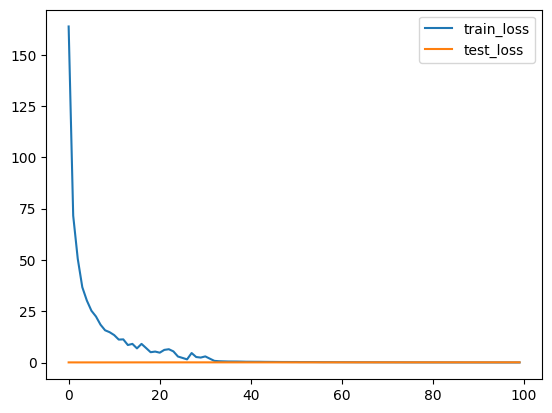

In [12]:
import pandas as pd
results = pd.DataFrame([])
results['train_loss']  = train_record
results['test_loss']  = test_record
results.plot.line(y=['train_loss', 'test_loss'])